In [15]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib import colors

%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import itertools
import random
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from tqdm import tqdm
from shutil import copyfile
import cv2
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from mpl_toolkits import mplot3d
import trimesh

In [2]:
##################
### Load Atlas ###
##################

atlas_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/jfrc_2018_rois_improve_reorient_transformed_nearest_neighbor.nii"
atlas = np.asarray(nib.load(atlas_path).get_data().squeeze(), dtype='float32')
atlas = ants.from_numpy(atlas)
atlas.set_spacing((.76,.76,.76))
atlas = ants.resample_image(atlas,(2,2,2),use_voxels=False)
#atlas = ants.resample_image(atlas,(.5,.5,.5),use_voxels=False)

In [3]:
atlas = atlas.numpy()

In [4]:
atlas_int = atlas.astype('uint8')
atlas_int.shape
roi_ints = np.unique(atlas_int)

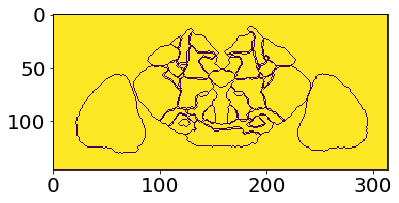

In [8]:
# THIS ONE #
z = 40
atlas_int = atlas.astype('uint8')
atlas_int.shape
roi_ints = np.unique(atlas_int)

canvas = np.ones(atlas_int.shape[:2])
for roi_int in roi_ints:
    empty = np.zeros(atlas_int[:,:,z].shape)
    empty[np.where(atlas_int[:,:,z]==roi_int)] = 1
    _, atlas_binary = cv2.threshold(empty, 0, 255, cv2.THRESH_BINARY)

    # contract and expand to remove spurious single voxels
    mask_eroded = binary_erosion(atlas_binary, structure=np.ones((2,2)))
    mask_dilated = binary_dilation(mask_eroded, iterations=2)

    # get contours
    #cv2.RETR_EXTERNAL or cv2.RETR_TREE
    contours, _ = cv2.findContours(mask_dilated.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # draw contours
    canvas = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
    #out = np.abs(out-1) #flip 0/1
    
plt.imshow(canvas.T)

In [9]:
roi_int = 26
empty = np.zeros(atlas_int.shape)
empty[np.where(atlas_int==roi_int)] = 1
_, atlas_binary = cv2.threshold(empty, 0, 255, cv2.THRESH_BINARY)

# contract and expand to remove spurious single voxels
mask_eroded = binary_erosion(atlas_binary, structure=np.ones((2,2,2)))
mask_dilated = binary_dilation(mask_eroded, iterations=2)

In [166]:
vertss = {}
facess = {}
for roi in rois.keys():
    empty = np.zeros(atlas_int_swap.shape)
    empty[np.where(atlas_int_swap[:,::-1,::-1]==roi)] = 1
    _, atlas_binary = cv2.threshold(empty, 0, 255, cv2.THRESH_BINARY)

    # contract and expand to remove spurious single voxels
    mask_eroded = binary_erosion(atlas_binary, structure=np.ones((2,2,2)))
    mask_dilated = binary_dilation(mask_eroded, iterations=2)
    
    verts, faces, normals, values = measure.marching_cubes_lewiner(mask_dilated, 0.5)
    vertss[roi] = verts
    facess[roi] = faces

In [163]:
atlas_int_swap.shape

(314, 91, 146)

In [165]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210818_3d_pickles/verts.pickle'
with open(save_file, 'wb') as f:
    pickle.dump(vertss, f)
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210818_3d_pickles/faces.pickle'
with open(save_file, 'wb') as f:
    pickle.dump(facess, f)

In [ ]:
# I think I want to switch the axes such that:
# x->z
# y->x
# z->y

In [140]:
atlas_int_swap = np.moveaxis(atlas_int,0,2)
atlas_int_swap = np.swapaxes(atlas_int_swap,0,2)

atlas_int_swap.shape

(314, 91, 146)

In [128]:
atlas_int.shape

(314, 146, 91)

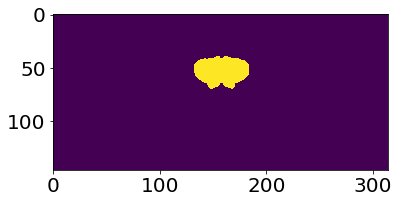

In [39]:
plt.imshow(mask_dilated[:,:,50].T)

In [44]:
cv2.resize(mask_dilated,mask_dilated.shape)

TypeError: Expected Ptr<cv::UMat> for argument '%s'

In [42]:
mask_dilated.shape

(314, 146, 91)

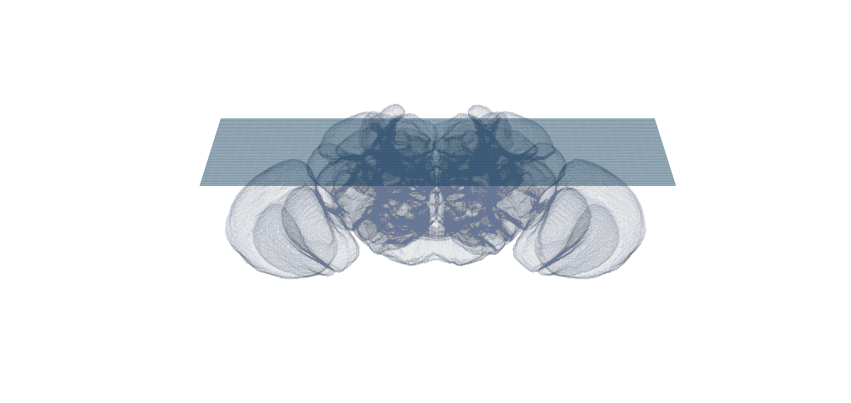

In [118]:
#smo = gaussian_filter(mask_dilated,sigma=.1)
#verts, faces, normals, values = measure.marching_cubes_lewiner(mask_dilated, 0.5)

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')  

for roi in rois.keys():
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(vertss[roi][facess[roi]])
    mesh.set_facecolor('#1f77b400') #00 means invisible
    mesh.set_edgecolor('#66789603') #05 means 2% alpha
    ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)
ax.view_init(elev=110, azim=90)

# set_axes_equal(ax) 
ax.set_xlim(0, 314)
ax.set_ylim(0, 146)
ax.set_zlim(0, 91)
ax.axis('off')

z, x = np.meshgrid(range(91), range(314))
y = np.ones(x.shape)*40
ax.plot_surface(x, y, z, alpha=0.5)

#plt.tight_layout()
#plt.show()

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

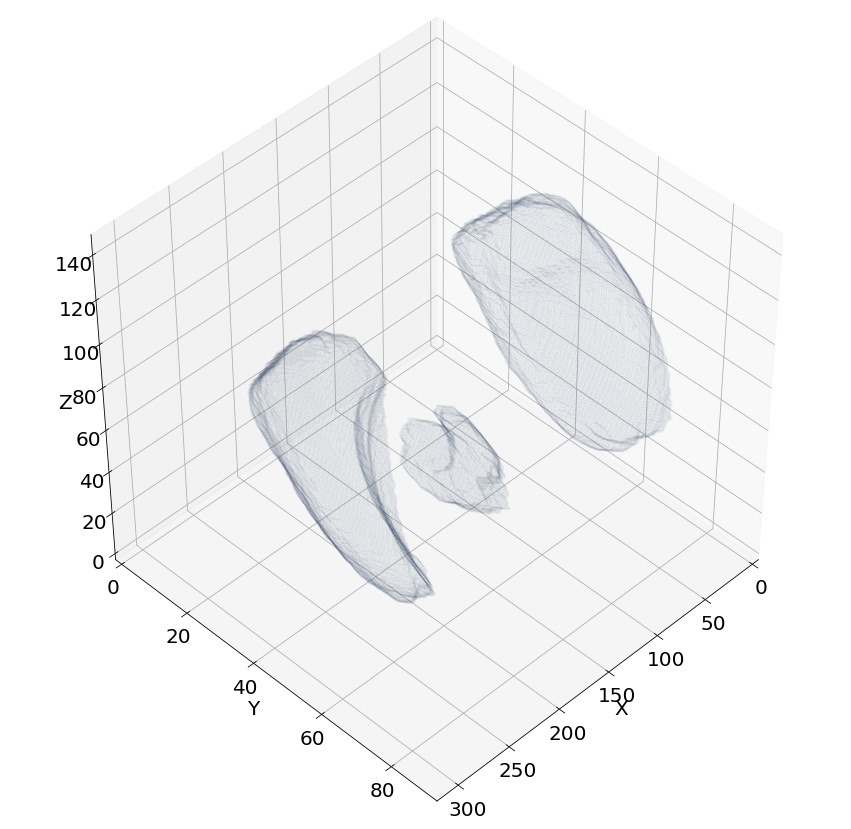

In [155]:
#smo = gaussian_filter(mask_dilated,sigma=.1)
#verts, faces, normals, values = measure.marching_cubes_lewiner(mask_dilated, 0.5)

fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
#ax.set_aspect('equal')  
#plt.set_box_aspect([1,1,1])

for roi in [26,71,25]:
    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(vertss[roi][facess[roi]])
    mesh.set_facecolor('#1f77b400')
    mesh.set_edgecolor('#66789605')
    
    
    #mesh.set_edgecolor('#1f77b430')
    #mesh.set_facecolor('#F6F6F6')
    #mesh.set_alpha(.1)
    ax.add_collection3d(mesh)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)
ax.view_init(elev=45, azim=45)

# x->z
# z->y
# y->x
#set_axes_equal(ax) 
#axisEqual3D(ax)
ax.set_xlim(0, 314)
ax.set_ylim(0, 91)
ax.set_zlim(0, 146)

# z, x = np.meshgrid(range(91), range(314))
# y = np.ones(x.shape)*40
# ax.plot_surface(x, y, z, alpha=0.1,color='k')

# y = np.ones(x.shape)*60
# ax.plot_surface(x, y, z, alpha=0.1,color='k')

# x=(0,314)
# y=(40,40)
# z=(91,91)
# ax.plot(x, y, z,color='k')
# x=(0,314)
# y=(40,40)
# z=(0,0)
# ax.plot(x, y, z,color='k')
# x=(314,314)
# y=(40,40)
# z=(0,91)
# ax.plot(x, y, z,color='k')
# x=(0,0)
# y=(40,40)
# z=(0,91)
# ax.plot(x, y, z,color='k')

#ax.axis('off')
#plt.tight_layout()
#plt.show()

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [154]:
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

In [151]:
import matplotlib

In [152]:
matplotlib.__version__

'3.0.2'

In [ ]:
# I think I want to switch the axes such that:
# x->z
# z->y
# y->x

In [113]:
z, x = np.meshgrid(range(91), range(314))
x.shape

(314, 91)

In [ ]:
xx, yy = np.meshgrid(range(10), range(10))
z = (9 - xx - yy) / 2 

# plot the plane
ax.plot_surface(xx, yy, z, alpha=0.5)

In [105]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [5]:
atlas.shape

(314, 146, 91)

In [6]:
edges = []
for z in range(91):
    edge = cv2.Canny(atlas_int[:,:,50],1,1)
    edges.append(edge)
edges = np.asarray(edges)
edges.shape

(91, 314, 146)

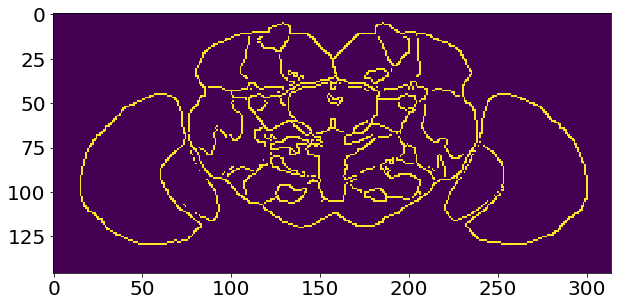

In [30]:
plt.figure(figsize=(10,10))
edges = cv2.Canny(atlas_int[:,:,50],1,1)
#edges = binary_dilation(edges, iterations=1)
#edges = scipy.ndimage.median_filter(edges,1)
#plt.imshow(edges[350:900,50:450].T)
plt.imshow(edges.T)

In [7]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.set_aspect('equal')  

ax.imshow(edges)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

#ax.view_init(elev=90, azim=90) # front view
#ax.view_init(elev=0, azim=90) # bottom view
#ax.view_init(elev=180, azim=90) # also bottom view, 180
ax.view_init(elev=90, azim=90)

# set_axes_equal(ax) 
ax.set_xlim(0, 314)
ax.set_ylim(0, 146)
ax.set_zlim(0, 91)

plt.tight_layout()
plt.show()

ValueError: Unknown projection '3d'

<Figure size 1080x1080 with 0 Axes>

In [32]:
# have manually swapped R and Ls
rois = {26: 'FB',
4: 'NO',
5: 'BU_L',
54: 'BU_R',
8: 'LAL_L',
56: 'LAL_R',
31: 'PVLP_L',
76: 'PVLP_R',
6: 'PB',
23: 'EB',
13: 'VES_L',  
40: 'EPA_L',
35: 'GOR_L',
11: 'AMMC_L',
60: 'VES_R', 
85: 'EPA_R',
80: 'GOR_R',
58: 'AMMC_R',
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_L',
75: 'AVLP_R',
24: 'AL_L',
70: 'AL_R',
64: 'MB_PED_R',
65: 'MB_VL_R',
66: 'MB_ML_R',
81: 'MB_CA_R',
17: 'MB_PED_L',
18: 'MB_VL_L',
19: 'MB_ML_L',
36: 'MB_CA_L',
32: 'IVLP_L',
77: 'IVLP_R',
10: 'CAN_L',
20: 'FLA_L',
57: 'CAN_R',
67: 'FLA_R',
27: 'SLP_L',
29: 'SMP_L',
33: 'PLP_L',
7: 'LH_L',
38: 'IPS_L',
37: 'SPS_L',
16: 'CRE_L',
39: 'SCL_L',
12: 'ICL_L',
15: 'ATL_L',
14: 'IB_L',
28: 'SIP_L',#####
72: 'SLP_R',   
74: 'SMP_R',
78: 'PLP_R',
55: 'LH_R',
83: 'IPS_R',
82: 'SPS_R',
63: 'CRE_R',
84: 'SCL_R',  
59: 'ICL_R',
62: 'ATL_R',
61: 'IB_R',
73: 'SIP_R',
25: 'MED_L',
3: 'LO_L',
22: 'LP_L',
34: 'AOTU_L',
71: 'MED_R',
53: 'LO_R',
69: 'LP_R',
79: 'AOTU_R'}